In [1]:
import numpy as np
import scipy as sc
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13582336/13568290 [==============================] - 0s 0us/step


In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.shape

(420551, 15)

In [5]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

In [6]:
samples_taken=300000
step = 6

past = 720    # using 720/6 =120 hrs of past data
future = 72   # to predict 72/6 =12 hrs in the future
learning_rate = 0.001
batch_size = 256
epochs = 10 

In [7]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [8]:
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]

In [9]:
features.index = df[date_time_key]
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(features)
features = pd.DataFrame(features)

features.head()


,0,1,2,3,4,5,6
0,0.814939,0.248632,0.037886,0.004782,0.081679,0.743213,0.997262
1,0.815430,0.242163,0.036294,0.004564,0.078843,0.749349,0.997231
2,0.815037,0.240504,0.035976,0.004347,0.078276,0.750666,0.997178
3,0.814840,0.243822,0.036772,0.004130,0.080545,0.747523,0.997193
4,0.814840,0.244485,0.036931,0.004130,0.080545,0.746954,0.997191


In [11]:
train_data = features.loc[0 : samples_taken - 1]
val_data = features.loc[samples_taken:]

In [12]:
start = past + future
end = start + samples_taken

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]   # ytrain is the temperature

sequence_length = int(past / step) # 720/6=120

In [14]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length, # to consider 120 past to predict future
    sampling_rate=step, # to split the data from every 10 mintues to every 1 hr
    batch_size=batch_size,
)

In [15]:
x_end = len(val_data) - past - future

label_start = samples_taken + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [16]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1170/1170 [==============================] - 164s 139ms/step - loss: 0.0080 - val_loss: 0.0063

Epoch 00001: val_loss improved from inf to 0.00630, saving model to model_checkpoint.h5
Epoch 2/10
1170/1170 [==============================] - 163s 140ms/step - loss: 0.0034 - val_loss: 0.0055

Epoch 00002: val_loss improved from 0.00630 to 0.00550, saving model to model_checkpoint.h5
Epoch 3/10
1170/1170 [==============================] - 163s 139ms/step - loss: 0.0029 - val_loss: 0.0050

Epoch 00003: val_loss improved from 0.00550 to 0.00498, saving model to model_checkpoint.h5
Epoch 4/10
1170/1170 [==============================] - 164s 140ms/step - loss: 0.0028 - val_loss: 0.0045

Epoch 00004: val_loss improved from 0.00498 to 0.00455, saving model to model_checkpoint.h5
Epoch 5/10
1170/1170 [==============================] - 160s 137ms/step - loss: 0.0027 - val_loss: 0.0042

Epoch 00005: val_loss improved from 0.00455 to 0.00420, saving model to model_checkpoint.h5
Epoch 6/1

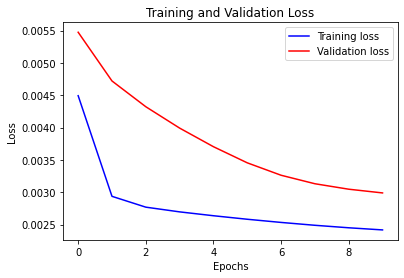

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

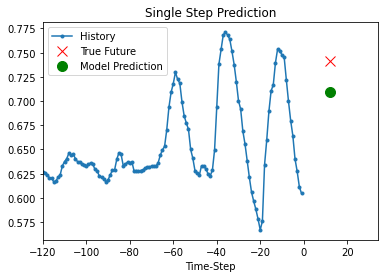

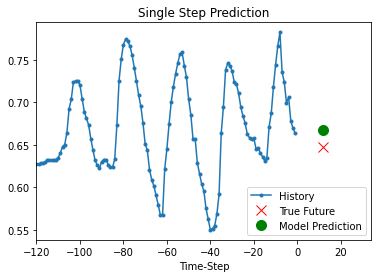

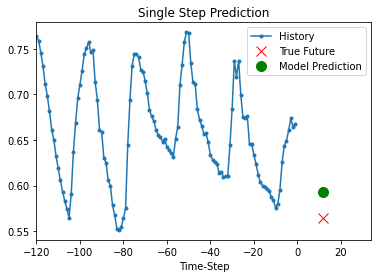

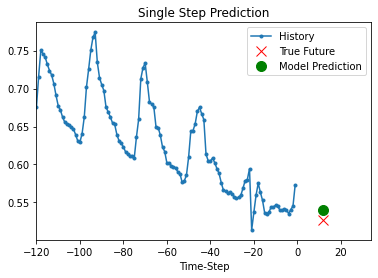

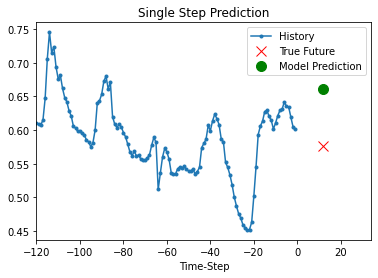

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )